# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from scipy.interpolate import griddata

import matplotlib.pyplot as plt

import requests

pd.options.display.max_columns = None

## LAND Events: OpenSea API

[OpenSea API](https://docs.opensea.io/reference/api-overview) is used to retrieve all the historical events (e.g., auctions, sales, transfers) related to LANDs from 2018 to 2020.

In [2]:
events_land = pd.read_csv("./data/events_land_181920.csv", low_memory=False)

# drop empty columns
empty_cols = events_land.columns[events_land.notna().sum() == 0]
events_land = events_land.drop(columns=empty_cols)

events_land

,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_seller_fee_basis_points,duration,ending_price,event_type,id,is_private,quantity,starting_price,total_price,listing_time,asset.id,asset.token_id,asset.num_sales,asset.background_color,asset.image_url,asset.image_preview_url,asset.image_thumbnail_url,asset.image_original_url,asset.name,asset.description,asset.external_link,asset.asset_contract.address,asset.asset_contract.asset_contract_type,asset.asset_contract.created_date,asset.asset_contract.name,asset.asset_contract.nft_version,asset.asset_contract.owner,asset.asset_contract.schema_name,asset.asset_contract.symbol,asset.asset_contract.description,asset.asset_contract.external_link,asset.asset_contract.image_url,asset.asset_contract.default_to_fiat,asset.asset_contract.dev_buyer_fee_basis_points,asset.asset_contract.dev_seller_fee_basis_points,asset.asset_contract.only_proxied_transfers,asset.asset_contract.opensea_buyer_fee_basis_points,asset.asset_contract.opensea_seller_fee_basis_points,asset.asset_contract.buyer_fee_basis_points,asset.asset_contract.seller_fee_basis_points,asset.asset_contract.payout_address,asset.permalink,asset.collection.banner_image_url,asset.collection.created_date,asset.collection.default_to_fiat,asset.collection.description,asset.collection.dev_buyer_fee_basis_points,asset.collection.dev_seller_fee_basis_points,asset.collection.discord_url,asset.collection.display_data.card_display_style,asset.collection.external_url,asset.collection.featured,asset.collection.featured_image_url,asset.collection.hidden,asset.collection.safelist_request_status,asset.collection.image_url,asset.collection.is_subject_to_whitelist,asset.collection.large_image_url,asset.collection.name,asset.collection.only_proxied_transfers,asset.collection.opensea_buyer_fee_basis_points,asset.collection.opensea_seller_fee_basis_points,asset.collection.payout_address,asset.collection.require_email,asset.collection.slug,asset.collection.twitter_username,asset.decimals,asset.token_metadata,asset.owner.profile_img_url,asset.owner.address,asset.owner.config,from_account.user.username,from_account.profile_img_url,from_account.address,from_account.config,to_account.user.username,to_account.profile_img_url,to_account.address,to_account.config,transaction.block_hash,transaction.block_number,transaction.from_account.user.username,transaction.from_account.profile_img_url,transaction.from_account.address,transaction.from_account.config,transaction.id,transaction.timestamp,transaction.to_account.profile_img_url,transaction.to_account.address,transaction.to_account.config,transaction.transaction_hash,transaction.transaction_index,asset.owner.user.username,payment_token.id,payment_token.symbol,payment_token.address,payment_token.image_url,payment_token.name,payment_token.decimals,payment_token.eth_price,payment_token.usd_price,seller.user.username,seller.profile_img_url,seller.address,seller.config,winner_account.profile_img_url,winner_account.address,winner_account.config,winner_account.user.username,transaction.to_account.user.username,dev_fee_payment_event.event_type,dev_fee_payment_event.event_timestamp,dev_fee_payment_event.payment_token.id,dev_fee_payment_event.payment_token.symbol,dev_fee_payment_event.payment_token.address,dev_fee_payment_event.payment_token.image_url,dev_fee_payment_event.payment_token.name,dev_fee_payment_event.payment_token.decimals,dev_fee_payment_event.payment_token.eth_price,dev_fee_payment_event.payment_token.usd_price,dev_fee_payment_event.transaction.block_hash,dev_fee_payment_event.transaction.block_number,dev_fee_payment_event.transaction.from_account.user.username,dev_fee_payment_event.transaction.from_account.profile_img_url,dev_fee_payment_event.transaction.from_account.address,dev_fee_payment_event.transaction.from_account.config,dev_fee_payment_event.transaction.id,dev_fee_payment_event.transaction.timestamp,dev_fee_payment_event.transaction.to_account.profile_img_url,

## LAND Details: Decentraland API

In [3]:
url_decentraland = "https://api.decentraland.org/"
response = requests.get(url_decentraland + "v2/tiles")
tiles = pd.DataFrame.from_dict(response.json()["data"], orient="index").reset_index(drop=True)
tiles = tiles.rename(columns={"id":"xy"})[["xy","x","y","tokenId","type",]]
tiles

,xy,x,y,tokenId,type
0,"-150,150",-150,150,1157920892373161954235709850086879078022276296...,district
1,"-150,149",-150,149,1157920892373161954235709850086879078022276296...,district
2,"-150,148",-150,148,1157920892373161954235709850086879078022276296...,district
3,"-150,147",-150,147,1157920892373161954235709850086879078022276296...,district
4,"-150,146",-150,146,1157920892373161954235709850086879078022276296...,district
...,...,...,...,...,...
92593,"163,63",163,63,55466025808112969544530061011378218467391,district
92594,"163,62",163,62,55466025808112969544530061011378218467390,district
92595,"163,61",163,61,55466025808112969544530061011378218467389,district
92596,"163,60",163,60,55466025808112969544530061011378218467388,district


* Merge the transaction table with LAND information

In [4]:
# merge transactions with LAND information
events_land = pd.merge(events_land, tiles, how="left", left_on="asset.token_id", right_on="tokenId")

In [5]:
# process decimals to study USD price
for v in ["bid_amount","starting_price","ending_price","total_price"]:
    events_land[v] = events_land.apply(lambda row: float(row[v]) / 10**row["payment_token.decimals"] \
                                       if row[v] is not None else row[v], axis=1)

In [8]:
cols = ["id","asset.token_id","xy","x","y","type",
        "created_date","transaction.timestamp","auction_type","event_type","bid_amount",
        "starting_price","ending_price","total_price",
        "payment_token.symbol","payment_token.usd_price",
        "asset.owner.address","from_account.address","to_account.address",]
events_land[cols]

,id,asset.token_id,xy,x,y,type,created_date,transaction.timestamp,auction_type,event_type,bid_amount,starting_price,ending_price,total_price,payment_token.symbol,payment_token.usd_price,asset.owner.address,from_account.address,to_account.address
0,6833472,1157920892373161954235709850086879078195820303...,"-100,-1",-100,-1,district,2018-12-01T08:03:48.179281,2018-12-01T08:02:58,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0x0000000000000000000000000000000000000000,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c
1,7520551,1157920892373161954235709850086879078195820303...,"-100,-1",-100,-1,district,2019-01-04T22:46:07.600500,2019-01-04T22:38:37,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c,0x959e104e1a4db6317fa58f8295f586e1a978c297
2,6834672,1157920892373161954235709850086879078195820303...,"-100,-10",-100,-10,district,2018-12-01T09:12:12.670699,2018-12-01T09:11:25,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0x0000000000000000000000000000000000000000,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c
3,7520412,1157920892373161954235709850086879078195820303...,"-100,-10",-100,-10,district,2019-01-04T22:44:26.596727,2019-01-04T22:38:37,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c,0x959e104e1a4db6317fa58f8295f586e1a978c297
4,26058524,1157920892373161954235709850086879078195820303...,"-100,-100",-100,-100,owned,2019-11-21T16:20:04.335769,2019-11-21T16:19:42,NaN,bid_entered,6000.0,NaN,NaN,NaN,MANA,3.32,0xa2efa94766ee867c91f71e8020a3c97ae687e5c3,0x2c96d35475b72066a22218c13dc36e4977c61c8c,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73800,6686660,1157920892373161954235709850086879078195820303...,"-99,97",-99,97,district,2018-11-23T18:13:42.831716,2018-11-23T18:12:45,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c,0x959e104e1a4db6317fa58f8295f586e1a978c297
73801,6614478,1157920892373161954235709850086879078195820303...,"-99,98",-99,98,district,2018-11-19T22:06:21.949870,2018-11-19T22:05:31,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0x0000000000000000000000000000000000000000,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c
73802,6686661,1157920892373161954235709850086879078195820303...,"-99,98",-99,98,district,2018-11-23T18:13:43.012376,2018-11-23T18:12:45,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c,0x959e104e1a4db6317fa58f8295f586e1a978c297
73803,6614432,1157920892373161954235709850086879078195820303...,"-99,99",-99,99,district,2018-11-19T22:03:57.630102,2018-11-19T22:03:09,NaN,transfer,NaN,NaN,NaN,NaN,NaN,NaN,0x959e104e1a4db6317fa58f8295f586e1a978c297,0x0000000000000000000000000000000000000000,0xf081eda01d8d3b10f6f93ff1459339b9ed174d3c


## Descriptive Statistics

In [9]:
# number of currently retrieved LANDs with transactions
events_land["xy"].nunique()

27014

In [10]:
events_land[cols]["event_type"].value_counts()

transfer         49561
created          11475
offer_entered     7276
bid_entered       2396
successful        1583
cancelled         1051
bid_withdrawn      462
approve              1
Name: event_type, dtype: int64

In [11]:
events_land["payment_token.symbol"].value_counts()

MANA    23659
WETH      357
ETH       186
DAI        18
USDC       14
SAI        10
Name: payment_token.symbol, dtype: int64

In [12]:
print("# unq owner:", events_land["asset.owner.address"].nunique())
print("# unq from:", events_land["from_account.address"].nunique())
print("# unq to:", events_land["to_account.address"].nunique())

# unq owner: 1492
# unq from: 1283
# unq to: 1200


<AxesSubplot:>

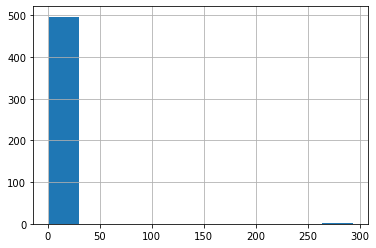

In [13]:
tmp = events_land[events_land["event_type"] == "successful"][cols]
tmp.groupby("asset.owner.address")["asset.token_id"].nunique().sort_values().hist()

### Average USD Price Visualization

In [14]:
tmp = events_land[events_land["event_type"] == "successful"].reset_index(drop=True)
tmp["total_price_usd"] = tmp["total_price"] * tmp["payment_token.usd_price"]
tmp = tmp.groupby(["x","y"])["total_price_usd"].mean().to_frame("avg_price_usd").reset_index()
tmp

,x,y,avg_price_usd
0,-150,-141,61800.00
1,-150,-140,22741.37
2,-150,-139,24689.10
3,-150,-138,25538.85
4,-150,-135,24395.00
...,...,...,...
908,-53,84,311300.00
909,-53,91,35375.00
910,-53,110,45704.50
911,-53,114,127350.00


In [15]:
tmp.describe()

,x,y,avg_price_usd
count,913.000000,913.00000,913.000000
mean,-98.998905,-40.69989,53773.740687
std,30.972062,69.11716,35042.671884
min,-150.000000,-150.00000,5412.359160
25%,-129.000000,-88.00000,33419.400000
50%,-97.000000,-51.00000,43470.000000
75%,-70.000000,-14.00000,61197.726800
max,-53.000000,150.00000,311300.000000


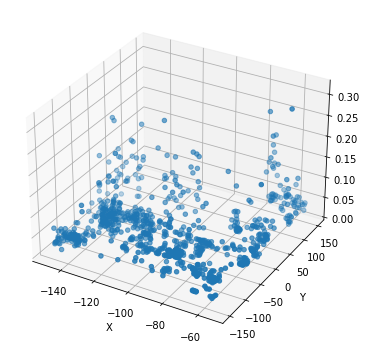

In [16]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection="3d")

ax.scatter3D(tmp.x, tmp.y, tmp["avg_price_usd"] / 10**6)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlim(0,)

plt.tight_layout()
plt.show()

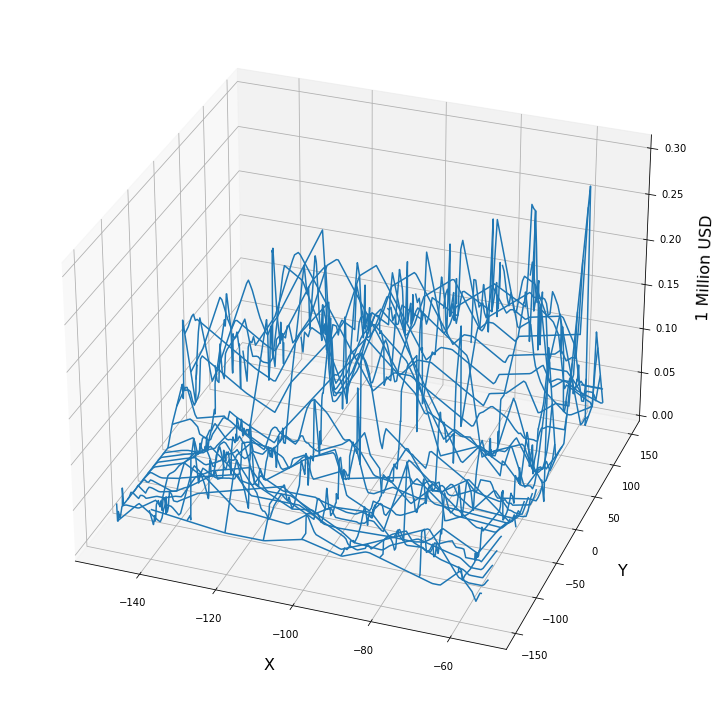

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

X = tmp.x
Y = tmp.y
Z = np.round(tmp["avg_price_usd"] / 10**6,2)

xi = np.linspace(X.min(), X.max(), (X.max()-X.min()+1)*2)
yi = np.linspace(Y.min(), Y.max(), (Y.max()-Y.min()+1)*2)
zi = griddata((X,Y), Z, (xi[None,:], yi[:,None]), method="linear")
xi, yi = np.meshgrid(xi, yi)

ax.plot_wireframe(xi, yi, zi, rstride=20, cstride=20)

ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.set_zlabel("1 Million USD", fontsize=16)
ax.set_zlim(0,)

ax.tick_params(axis='both', which='major', pad=8)
ax.xaxis.labelpad, ax.yaxis.labelpad, ax.zaxis.labelpad = 20, 20, 20
ax.view_init(30, 290)

plt.tight_layout()
# plt.savefig("lands_181920.png", dpi=300)
plt.show()